In [74]:
fillers = [
        r"\bright\b\s?",
        r"\byou know\b\s?",
        r"\bi think\b\s?",
        r"\bbut i think\b\s?",
        r"\bso to speak\b\s?",
        r"\blike\b\s?",
        r"\bi mean\b\s?",
        r"\bso\b\s?",
        r"\bactually\b\s?",
        r"\bbasically\b\s?",
        r"\bokay\b\s?",
        r"\byeah\b\s?",
        r"\byeah okay\b\s?",
        r"\byes\b\s?",
        r"\bthe\b\s?",
        r"\band\b\s?",
        
        r"\bchuckle\b\s?",
        r"\blaughter\b\s?",
        r"\bpause\b\s?",
        r"\bnoise\b\s?",
        r"\bmusic\b\s?",
        r"\bapplause\b\s?",
        r"\bvocalization\b\s?",
        r"\bvideo playback\b\s?",
        r"\bautomated voice\b\s?",
        r"\bforeign language\b\s?",
        r"\boverlapping conversation\b\s?",
        r"\bbackground conversation\b\s?",
        r"\bstart-paren\b\s?",
        r"\bend-paren\b\s?",
        
        r"\ba\b\s?",
        r"\bto\b\s?"]

In [86]:
baddos = '|'.join(fillers)
#re.sub(baddos,'',st)
#substitute_finder.sub(match_to_substitution, st)

In [224]:
st = 'my the s23 like 2 half-hearted I am 008966 a man man-whore 00089 e s   s2  a s3'

In [209]:
re.sub('\s*$','',st)

'my the s23 like 2 half-hearted I am 008966 a man man-whore 00089 e s   s2  a'

In [112]:
fake = np.ones([1,300])*np.random.randn(300)
fake2 = np.ones([1,300])*np.random.randn(300)

In [131]:
fake_mean = np.asarray(np.mean(fake,axis=0)).reshape([-1,1])
fake2_mean = np.asarray(np.mean(fake2,axis=0)).reshape([-1,1])

In [136]:
from scipy.spatial.distance import cosine

In [148]:
zips = np.ones(300).reshape([-1,1])
zips2 = np.ones(300).reshape([-1,1])

In [149]:
cosine(fake_mean,fake2_mean)

0.94604251334663247

In [150]:
cosine(zips,zips2)

2.2204460492503131e-16

In [234]:
st = 'my the s23 like 2 half-hearted I am 008966 a man st man-whore 00089 e s s2 a s3'

In [235]:
st

'my the s23 like 2 half-hearted I am 008966 a man st man-whore 00089 e s s2 a s3'

In [236]:
re.sub(r"\bs\d{0,2}\b",'',st)

'my the  like 2 half-hearted I am 008966 a man st man-whore 00089 e   a '

In [242]:
a = re.sub(r"\bs\d{0,2}\b",'speaker',st)
a = re.sub(r"\b\d{5,6}\b",'timestamp',a)
a = re.sub(r'\d+','digit',a)
a = re.sub(r'-',' ',a)
a = re.sub(r"\ba\b",'one',a)
a
#re.sub(r"\s*$",'',a)

'my the speaker like digit half hearted I am timestamp one man st man whore timestamp e speaker speaker one speaker'

In [259]:
(np.zeros(10)+1e-3).shape

(10,)

In [309]:
check.vocab_dict['the']

11

In [5]:
from __future__ import print_function
import os
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import euclidean_distances,confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import pandas as pd
from pyemd import emd
import tensorflow as tf
from gensim.models.word2vec import Word2Vec


class error_checker():
    """
    Error checker class that builds embeddings upon instantiation, is capable
    of being retrained, making predictions, and inspecting performance.
    expects data_path upon instantiation, which is a directory in which
    the 3000000x300 pretrained Google News vectors binary file should be at
    very least, and will create embeddings and vocab (embed.dat, embed.vocab)
    in that directory if they do not exist. In order to perform training, the
    class expects 'dataset.csv' as well, which should have no header, and
    three entries per datapoint (Error [1 for minor, 2 for major],
    String 1 [first transcription],String 2 [second transcription]). Some
    files will be created as a result of training (model.ckpt, fuzzy.csv).
    """
    def __init__(self,data_path):

        self.data_path = data_path
        self._save_path = os.path.join(self.data_path,'model.ckpt')
        self.epsilon = 1e-4

        binary_file = os.path.join(self.data_path,
                                   'GoogleNews-vectors-negative300.bin')
        w2v_dat = os.path.join(self.data_path,'embed.dat')
        w2v_vocab = os.path.join(self.data_path,'embed.vocab')

        if not os.path.exists(w2v_dat):
            print("Caching word embeddings in memmapped format.                     Please be patient...")
            wv = Word2Vec.load_word2vec_format(
                binary_file,binary=True)
            fp = np.memmap(w2v_dat, dtype=np.double,
                           mode='w+', shape=wv.syn0.shape)
            fp[:] = wv.syn0[:]
            with open(w2v_vocab, "w") as f:
                for _, w in sorted((voc.index, word)                                    for word, voc in wv.vocab.items()):
                    print(w, file=f)
            del fp, wv

        # create word embeddings and mapping of vocabulary item to index
        self.embeddings = np.memmap(w2v_dat, dtype=np.float64,
                                    mode="r", shape=(3000000, 300))
        with open(w2v_vocab) as f:
            vocab_list = map(lambda string: string.strip(), f.readlines())
        self.vocab_dict = {w: i for i, w in enumerate(vocab_list)}

        # mean of 20 rarest words, used as a stand-in for pairwise distances
        # if a word is out-of-vocabulary
        avg_rare_word = np.mean(np.vstack(self.embeddings[-20:]),axis=0)
        self.bad_row = np.asarray([avg_rare_word])

    def _index_check(self,features):
        total = 0
        for word in features:
            if word in self.vocab_dict:
                total+=self.vocab_dict[word]
        return total

    def _get_dist(self,s_1,s_2):
        """Return counts of in-vocabulary and out-of-vocabulary items per
        string, means of embeddings per string, and Word Mover's Distance
        between the two. Word embeddings and mappings were created upon
        initialization of the class instance, and WMD with emd()
        (Earth Mover's Distance) from PyEMD. Final shape is [1,612].
        """

        results_ = []
        
        ###############
        #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
        #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
        #s_1 = re.sub(r'\d+','digit',s_1)
        s_1 = re.sub(r'-',' ',s_1)
        s_1 = re.sub(r"\ba\b",'one',s_1)
        
        #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
        #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
        #s_2 = re.sub(r'\d+','digit',s_2)
        s_2 = re.sub(r'-',' ',s_2)
        s_2 = re.sub(r"\ba\b",'one',s_2)
        
                
        # from FuzzyWuzzy: ratio, partial, sort, set
        fw_ratio = fuzz.ratio(s_1,s_2)
        fw_partial = fuzz.partial_ratio(s_1,s_2)
        fw_sort = fuzz.token_sort_ratio(s_1,s_2)
        fw_set = fuzz.token_set_ratio(s_1,s_2)

        # string lengths for each pair
        str1_len = len(s_1)
        str2_len = len(s_2)

        # combine string metrics together and get scores from _get_dist()
        string_metrics = [fw_ratio,fw_partial,fw_sort,fw_set,str1_len,str2_len]
        results_.extend(string_metrics)
        
        # moved this up here from mean of word embeddings section
        s1_features = s_1.split()
        s2_features = s_2.split()

        # sum of indices; proxy for word rarity
        ##results_.append(self._index_check(s1_features))
        ##results_.append(self._index_check(s2_features))        
        
        
        # number of out-of-vocabulary and in-vocabulary items
        #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
        #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
        #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
        #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
        #results_.append(s_1_bad)
        #results_.append(s_1_good)
        #results_.append(s_2_bad)
        #results_.append(s_2_good)

        # mean of word embeddings per string (0s if no items are in embeddings)
        # shape is [1,300] per string
        S1_ = self.embeddings[[self.vocab_dict[w] for w in s1_features if w in self.vocab_dict]]
        S2_ = self.embeddings[[self.vocab_dict[w] for w in s2_features if w in self.vocab_dict]]
        if S1_.shape[0]==0:
            S1_ = np.zeros((1,300))+self.epsilon
        if S2_.shape[0]==0:
            S2_ = np.zeros((1,300))+self.epsilon
        S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
        S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
        results_.extend(S1_)
        results_.extend(S2_)
        results_.append(cosine(S1_,S2_))

        #try:
        # fit CV on words with or without a single quote
        vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
        features = np.asarray(vect.get_feature_names())

        # get 'flow' vectors
        v_1, v_2 = vect.transform([s_1, s_2])
        v_1 = v_1.toarray().ravel().astype(np.float64)
        v_2 = v_2.toarray().ravel().astype(np.float64)

        # normalize vectors so as not to reward shorter strings in WMD
        v_1 /= (v_1.sum()+self.epsilon)
        v_2 /= (v_2.sum()+self.epsilon)

        # for each out-of-vocabulary item, use the average of the 20
        # rarest words' embeddings to represent it in the distance calc       
        W_ = np.ndarray([0,300])
        
        # get distance matrix for words in both strings
        for w in features:
            if w in self.vocab_dict:
                W_ = np.append(W_,self.embeddings[[self.vocab_dict[w]]],axis=0)
            else:
                W_ = np.append(W_,self.bad_row,axis=0)
        
        # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
        D_euclidean = euclidean_distances(W_).astype(np.float64)
        D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

        # using EMD (Earth Mover's Distance) from PyEMD
        distances_euclidean = emd(v_1,v_2,D_euclidean)
        distances_cosine = emd(v_1,v_2,D_cosine)

        # both WMD calculations (euclidean and cosine)
        results_.append(distances_euclidean)
        results_.append(distances_cosine)
        
        return results_

    def _data_generator(self,str_1,str_2):
        """
        Transform two strings into a vector of 612 features as expected by the
        TensorFlow model.
        """
        
        X = self._get_dist(str_1,str_2)

        # X to be fed to the network
        X = np.asarray(X).reshape((-1,609)) #612)) #12))#"""612))"""

        return X

    def _train_data_generator(self,shuffle,seed):
        """
        Transforms self.training_set ('dataset.csv' in self.data_path) and
        self.fuzzy_path ('fuzzy.csv' in self.data_path) into useful features
        to train the model, and transforms error type (1 for minor,
        2 for major) into one-hot vector of length 2 (i.e., [1,0] for minor,
        [0,1] for major). Data are shuffled by default, as they are sorted by
        error type in the original training sets.

        Returns: X, Y, shuffled indices, original X (as pairs of strings)
            The latter two are included purely for examining performance.
        """

        # original training set cols are Error_type, Str_1, Str_2
        X_in = np.genfromtxt(self.training_set,
                      delimiter=',',usecols=(1,2),dtype=str)
        Y_in = np.genfromtxt(self.training_set,
                      delimiter=',',usecols=(0)).reshape((-1,1))

        X = []
        Y = []
        bad = []
        
        for i,strings in enumerate(X_in):
            try:
                scores = self._get_dist(strings[0],strings[1])
                X.extend(scores)

                # target
                Y.append(Y_in[i])
            except:
                bad.append(i)
                continue
        self.bad = bad
        
        X = np.asarray(X).reshape((-1,609))#612)) #12))#"""612))"""
        Y = np.asarray(Y).reshape((-1,1))

        # unshuffled indices
        indices = range(X.shape[0])

        # randomly shuffle the data
        if shuffle:
            np.random.seed(seed)
            np.random.shuffle(indices)
            X = X[indices]
            Y = Y[indices]

        # transform Y from either 1 or 2 to a one-hot vector ([1,0] or [0,1])
        y_list = []
        for i, label in enumerate(Y):
            if label == 2:
                label = 1
                y_list.append(np.insert(label,0,0))
            elif label == 1:
                y_list.append(np.insert(label,1,0))
            else:
                raise ValueError("Y label must be either 1 (minor) or                                     2 (major). Problem at index ", indices[i])
        Y = np.asarray(y_list)

        return X,Y,indices,X_in

    def _batch_norm_wrapper(self,inputs,training,decay=0.999):

        scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
        beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
        pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]),
                               trainable=False)
        pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]),
                              trainable=False)

        if training:
            batch_mean,batch_var = tf.nn.moments(inputs,[0])
            train_mean = pop_mean.assign(pop_mean*decay+batch_mean*(1-decay))
            train_var = pop_var.assign(pop_var*decay+batch_var*(1-decay))
            with tf.control_dependencies([train_mean,train_var]):
                return tf.nn.batch_normalization(inputs,
                                batch_mean,batch_var,beta,scale,self.epsilon)
        else:
            return tf.nn.batch_normalization(inputs,
                            pop_mean,pop_var,beta,scale,self.epsilon)

    def _build_graph(self,training):

        # inputs and outputs (latter are one-hot vectors)
        X = tf.placeholder(tf.float32, shape=[None,609])#612])#12])#"""612])"""
        Y = tf.placeholder(tf.float32, shape=[None,2])
        lr = tf.placeholder(tf.float32)
        glob_step = tf.Variable(0,dtype=tf.float32,trainable=False)

        weight_shape1 = [609,256]#612 #"""12"""
        weight_shape2 = [256,128]
        weight_shape3 = [128,16]
        weight_shape4 = [16,2]

        [n_inputs1,n_outputs1,n_inputs3,n_outputs3,n_outputs_final] =             weight_shape1[0],weight_shape1[1],weight_shape3[0],             weight_shape3[1],weight_shape4[1]

        init_range1 = tf.sqrt(6.0/(n_inputs1+n_outputs1))
        init_range2 = tf.sqrt(6.0/(n_outputs1+n_inputs3))
        init_range3 = tf.sqrt(6.0/(n_inputs3+n_outputs3))
        init_range4 = tf.sqrt(6.0/(n_outputs3+n_outputs_final))
        w1 = tf.Variable(tf.random_uniform(weight_shape1,
                                           -init_range1,init_range1),name='w1')
        w2 = tf.Variable(tf.random_uniform(weight_shape2,
                                           -init_range2,init_range2),name='w2')
        w3 = tf.Variable(tf.random_uniform(weight_shape3,
                                           -init_range3,init_range3),name='w3')
        w4 = tf.Variable(tf.random_uniform(weight_shape4,
                                           -init_range4,init_range4),name='w4')
        b = tf.Variable(tf.constant(.1,shape=[n_outputs_final]))


        # network - batch normalization in training, relu activations
        dot1 = tf.matmul(X,w1)
        batch_normed1 = self._batch_norm_wrapper(dot1,training)
        rel1 = tf.nn.relu(batch_normed1)

        dot2 = tf.matmul(rel1,w2)
        batch_normed2 = self._batch_norm_wrapper(dot2,training)
        rel2 = tf.nn.relu(batch_normed2)

        dot3 = tf.matmul(rel2,w3)
        batch_normed3 = self._batch_norm_wrapper(dot3,training)
        rel3 = tf.nn.relu(batch_normed3)

        # softmax layer
        logits = tf.matmul(rel3,w4)+b
        probs_x = tf.nn.softmax(logits)

        # cost:
        #    per pair
        rows_of_cost =             tf.nn.softmax_cross_entropy_with_logits(logits,Y,
                                                    name='rows_of_cost')
        #    average over all pairs
        cost = tf.reduce_mean(rows_of_cost,reduction_indices=None,
                              keep_dims=False,name='cost')

        # gradients and training
        opt = tf.train.AdagradOptimizer(learning_rate=lr)
        train_op = opt.minimize(cost,global_step=glob_step,
                                var_list=[w1,w2,w3,w4,b])

        # predictions and accuracy
        correct_prediction = tf.equal(tf.arg_max(probs_x,1),tf.arg_max(Y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

        return (X,Y),cost,train_op,accuracy,probs_x,lr,tf.train.Saver()

    def train(self,shuffle=True,seed=42,validation_size=.2,test_size=.05):

        """
        Train the model on the data stored in 'dataset.csv' in self.data_path.
        This will check for a file named 'fuzzy.csv' first, which is the output
        of self._get_fuzzy(), and creates it if it is not present.

        Expected format of 'dataset.csv':
            no header, three entries per row of (Error,String 1,String 2).
            Error is an integer (1 for minor, 2 for major)
        """

        self.training_set = os.path.join(self.data_path,'dataset.csv')

        # check if data has already been split before generating and splitting
        try:
            assert len(self.x_train)==len(self.raw_X)-int(len(self.raw_X)*(validation_size+test_size))
        except (AssertionError,AttributeError):
            print("Generating and splitting data...")
            X_data,Y_data,self.shuffled_idx,self.raw_X = self._train_data_generator(shuffle,seed)
            
            # create split indices for validation, test, and train sets
            self._validation_test_split_idx = int(len(Y_data)*validation_size)
            self._train_test_split_idx = int(len(Y_data)*test_size)+self._validation_test_split_idx

            # split data
            self.x_validation = X_data[:self._validation_test_split_idx]
            self.x_test = X_data[self._validation_test_split_idx:
                                 self._train_test_split_idx]
            self.x_train = X_data[self._train_test_split_idx:]
            self.y_validation = Y_data[:self._validation_test_split_idx]
            self.y_test = Y_data[self._validation_test_split_idx:
                                 self._train_test_split_idx]
            self.y_train = Y_data[self._train_test_split_idx:]
                
        print("Training model...")
        # build and run network in training mode
        tf.reset_default_graph()
        (X,Y),cost,train_op,accuracy,probs_x,lr,saver = self._build_graph(training=True)
        
        # just putting 0 in so first accuracy can be compared to something for now
        self.accuracy = [0]
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            mini_batch_size = 32
            start_end = zip(range(0,len(self.x_train),mini_batch_size),
                           range(mini_batch_size,len(self.x_train)+1,
                                 mini_batch_size))
            cost_list = []

            # number of training epochs
            num_passes = 31
            for pass_i in range(num_passes):
                for (s,e) in start_end:

                    # learning rate scheduling
                    #if pass_i < 20:
                    cost_list.append(sess.run(
                            [cost],feed_dict={X:self.x_train[s:e,],
                                              Y:self.y_train[s:e],
                                              lr:.09}))
                    sess.run([train_op],feed_dict={X:self.x_train[s:e,],
                                                   Y:self.y_train[s:e],
                                                   lr:.09})
                    #else:
                    #    cost_list.append(sess.run(
                    #            [cost],feed_dict={X:self.x_train[s:e,],
                    #                              Y:self.y_train[s:e],
                    #                              lr:.05}))
                    #    sess.run([train_op],feed_dict={X:self.x_train[s:e,],
                    #                                   Y:self.y_train[s:e],
                    #                                   lr:.05})
                # show current accuracy
                if pass_i % 5 == 0:
                    result = sess.run([accuracy],
                                      feed_dict={X:self.x_validation,
                                                 Y:self.y_validation})
                    print('Pass number: ',pass_i,
                          ' -- validation set accuracy: ',result[0])
                    
                    # save model in self._save_path if accuracy is better than any previous run
                    if result[0] > max(self.accuracy):
                        save_path = saver.save(sess,self._save_path)
                    self.accuracy.append(result[0])

                    
            # save cost and result lists for examining model performance
            self._cost_list = cost_list
            self._result_list = sess.run([tf.arg_max(probs_x,1)],
                                         feed_dict={X:self.x_test,
                                                    Y:self.y_test})
            print("Model saved in file: {}".format(save_path))

    def check_results(self):
        """
        Prints a confusion matrix of performance on the test set,
        and instantiates lists of True Positive, True Negative,
        False Positive, and False Negative for inspection as
        self._TP, self._TN, self._FP, self._FN.
        """

        # print confusion matrix
        true_y_labels = np.array(self.y_test[:,1])
        print('\t\tPredicted:')
        print('\t\tmin. maj.')
        print('Actual:\t min.',
              confusion_matrix(true_y_labels,self._result_list[0])[0])
        print('    \t maj.',
              confusion_matrix(true_y_labels,self._result_list[0])[1])

        # identify predicted and true positives and negatives
        predicted_pos = np.where(self._result_list[0]==1)
        predicted_neg = np.where(self._result_list[0]==0)
        actual_pos = np.where(np.argmax(self.y_test,1)==1)
        actual_neg = np.where(np.argmax(self.y_test,1)==0)

        # indices of shuffled and split data (just y_test)
        true_pos = np.intersect1d(predicted_pos,actual_pos).tolist()
        true_neg = np.intersect1d(predicted_neg,actual_neg).tolist()
        false_pos = np.intersect1d(predicted_pos,actual_neg).tolist()
        false_neg = np.intersect1d(predicted_neg,actual_pos).tolist()
        y_indices = self.shuffled_idx[self._validation_test_split_idx:
                                      self._train_test_split_idx]

        # create lists of true and false positives and negatives
        self._TP = [list(self.raw_X[y_indices[i]]) for i in true_pos]
        self._TN = [list(self.raw_X[y_indices[i]]) for i in true_neg]
        self._FP = [list(self.raw_X[y_indices[i]]) for i in false_pos]
        self._FN = [list(self.raw_X[y_indices[i]]) for i in false_neg]

    def predict(self,csv_file):
        """
        Predicts the type of error between the two strings in each row of
        a CSV file.

        Returns:
            0 for minor, 1 for major,
            'No error' for identical strings,
            and 'Unknown' if a prediction cannot be made (could change to 0).
        """
        predictions = []
        # build graph and initialize session
        tf.reset_default_graph()
        (X,_),_,_,_,pred_y,lr,saver = self._build_graph(training=False)
        with tf.Session() as sess:
            sess.run(tf.initialize_all_variables())
            saver.restore(sess,self._save_path)

            # generate calculations from 2d array of input strings
            for row in np.genfromtxt(csv_file,dtype='str',delimiter=','):
                str_1,str_2 = row[0],row[1]

                # strings identical
                if str_1 == str_2:
                    predictions.append('No error')
                    continue

                # model prediction
                try:
                    pred = sess.run([tf.arg_max(pred_y,1)],
                                    feed_dict=\
                                    {X: self._data_generator(str_1,str_2)})
                    predictions.append(str(pred[0][0]+1))

                # can't predict
                except:
                    predictions.append('Unknown')
        
        print(','.join(predictions))


In [428]:
#GRU cell
#mean vector back in there#
#before/after subs
#take out cosine to see 

In [6]:
path = '/users/rutherford/desktop/data'
check = error_checker(path)

In [7]:
# wasn't breaking 73. removed 7 features. now peaks at 83 early on
# undoing string replacements for speaker, timestamp, and digit - very slightly beter, stays above 83 whole time
# new dataset - 91.39
# keeping lr at .1 the whole time - 91218 at best (twice exact same)
# adding back in rarity proxy - ALL 89268
# taking out rarity proxy, putting back in good and bad counts -- 913058 best at 5. now lr .09 same
# with cosine, without rarity or good/bad counts -- 913997

# is dropout really not worth putting back in?
# tanh?
check.train()

Generating and splitting data...
Training model...


ValueError: Cannot feed value of shape (0,) for Tensor u'Placeholder_1:0', which has shape '(?, 2)'

In [451]:
check.predict("/Users/Rutherford/Desktop/data/data.csv")

2,1,1,1,1,1,1,2,1,1,1,2,No error,2,1,1,1,1,1,1,2,2,1,1,1,1,1


In [453]:
np.genfromtxt("/Users/Rutherford/Desktop/data/data.csv",dtype='str',delimiter=',')

array([['thing', 'thong'],
       ['chinamen', 'tiananmen'],
       ['this is the place', ' that is her face'],
       ['and so this', 'this'],
       ['triumphant', 'triumph'],
       ["she'll", 'should'],
       ['006789 s1', '555943 s3'],
       ['triumphant', 'triumvirate'],
       ['plaintiffs', "a plaintiff's"],
       ['down and', 'down or'],
       ['sometimes', 'i think sometimes'],
       ['word', 'org'],
       ['fifteen miles', 'fifteen miles'],
       ['corroborate', 'collaborate'],
       ['cats', 'cat'],
       ['finger', 'fingers'],
       ['salamander', 'salamanders'],
       ['salivate', 'salivated'],
       ['retrieve', 'retrieved'],
       ['emerge', 'emerging'],
       ['think', 'thought'],
       ['fast', 'fasted'],
       ['brigadeer', 'brigadier'],
       ['combuter', 'computer'],
       ['computer', 'combuter'],
       ['slivate', 'salivate'],
       ['nonsneese words in pairs', 'nonsense words in pairs']], 
      dtype='|S24')

In [449]:
check.y_train.shape

(55946, 2)

In [448]:
sum(np.argmax(check.y_train,axis=1))

6039

In [433]:
check.check_results()

		Predicted:
		min. maj.
Actual:	 min. [3222  114]
    	 maj. [214 179]


In [435]:
check._FN

[['15', 'finish paying'],
 ["let's say", 'and so'],
 ['you wear', "you're wearing"],
 ["i don't know that's", "that's"],
 ["that's", 'set'],
 ['myself', 'myself in these interviews'],
 ["didn't wanna get", 'did when i got'],
 ['no positive', 'positive'],
 ['familiarwiwith', 'familiar with this problem'],
 ['____', ''],
 ['____ staff', 'it will be staff'],
 ["'til", 'to'],
 ['was always', 'also'],
 ['what sit', "what's"],
 ['this is called', "let's just call"],
 ["i'll suffer", "i've suffered"],
 ["come of those we'd be", 'loose we were only'],
 ['this constant', "wisconsin's"],
 ['leukaemia and', 'leukemia and'],
 ['equity malpractices', 'equity'],
 ['please', 'jeez'],
 ['go', 'come'],
 ['fix', 'fixture'],
 ["i'll want to", "it'll"],
 ['baby fat', 'babies so i have'],
 ['how to get there', 'by looking at that'],
 ['valuable', 'valuable valuable'],
 ['pack', 'pocket'],
 ['just', 'need'],
 ['', "what i'm saying is"],
 ['', 'tap water laughter'],
 ['got', 'gone'],
 ['institute for physiqu

In [251]:
s_1 = "help a man with 2 tricks"
s_2 = "had the pan kick you figs"
s1_features = s_1.split()
s2_features = s_2.split()
S1_ = check.embeddings[[check.vocab_dict[w] for w in s1_features if w in check.vocab_dict]]
S2_ = check.embeddings[[check.vocab_dict[w] for w in s2_features if w in check.vocab_dict]]
if S1_.shape[0]==0:
    S1_ = np.ones((1,300))
if S2_.shape[0]==0:
    S2_ = np.ones((1,300))
S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])

In [254]:
#np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
S1_

array([[ 0.1171875 ],
       [ 0.02016602],
       [ 0.03173828],
       [ 0.06984863],
       [-0.09223633],
       [ 0.02331696],
       [-0.08835449],
       [-0.03043213],
       [ 0.01704102],
       [ 0.00200043],
       [-0.01826172],
       [-0.13187256],
       [-0.01455078],
       [-0.02015381],
       [-0.09570312],
       [ 0.04291992],
       [-0.03383789],
       [ 0.07277832],
       [-0.01466064],
       [-0.06610718],
       [-0.02854004],
       [-0.01780701],
       [ 0.08985596],
       [-0.07788086],
       [ 0.03791504],
       [-0.03056641],
       [-0.14462891],
       [ 0.08963623],
       [ 0.06392822],
       [-0.01276855],
       [-0.00561523],
       [ 0.00458984],
       [-0.06914062],
       [-0.13850098],
       [-0.10505371],
       [ 0.08625488],
       [ 0.05874023],
       [ 0.04329224],
       [ 0.12088623],
       [ 0.14986572],
       [ 0.0517334 ],
       [ 0.00634766],
       [ 0.03461914],
       [ 0.0427124 ],
       [ 0.0179657 ],
       [-0

In [248]:
check._get_dist('help','had')

[29,
 33,
 29,
 29,
 4,
 3,
 0,
 1,
 0,
 1,
 0.86971835432000122,
 2.592264513858284,
 0.8696313911808831]

In [ ]:
???

In [100]:
# 81 with normal stuff
# 80.79 but bad with 10% val, 5% test
# 81 with 35% val, 5% test
# 80.6 more FN than TP with 65% val, 5% test
# 82.9 with cleaned set and 25% 5%
# 83.0 AT PASS 15 (827) with numbers and dashes gone
# 83.1 AT PASS 20 (8288) everything in get_dist
# all fillers and metas and re.subs --- no 824 or so
check.check_results()

		Predicted:
		min. maj.
Actual:	 min. [2564  260]
    	 maj. [409 692]


In [103]:
check._get_dist('employers','employees')

[89,
 89,
 89,
 89,
 9,
 9,
 0,
 1,
 0,
 1,
 0.018310546875,
 -0.1181640625,
 0.040283203125,
 0.35546875,
 0.1533203125,
 -0.2021484375,
 -0.051513671875,
 0.259765625,
 0.00958251953125,
 0.2392578125,
 0.06396484375,
 0.1025390625,
 -0.07177734375,
 0.0142822265625,
 -0.07080078125,
 0.244140625,
 0.1650390625,
 0.3984375,
 -0.0037994384765625,
 -0.08935546875,
 0.0458984375,
 -0.0252685546875,
 0.07373046875,
 0.0220947265625,
 0.216796875,
 -0.01507568359375,
 -0.09716796875,
 0.01806640625,
 0.016845703125,
 0.033935546875,
 -0.1328125,
 -0.1337890625,
 0.01171875,
 -0.275390625,
 -0.032958984375,
 -0.01275634765625,
 0.236328125,
 0.263671875,
 0.0147705078125,
 0.11328125,
 -0.044677734375,
 0.0030975341796875,
 0.036376953125,
 -0.130859375,
 -0.21484375,
 -0.240234375,
 -0.10888671875,
 0.08740234375,
 0.00052642822265625,
 0.007293701171875,
 -0.07958984375,
 -0.2333984375,
 -0.0498046875,
 0.236328125,
 -0.0113525390625,
 -0.302734375,
 -0.001129150390625,
 -0.07861328125,


In [102]:
check._FN

[['____', 'so that we'],
 ['____', 'san'],
 ['that ____', "that's been"],
 ["i've run out", "right now it's 7 instead"],
 ['employers', 'employees'],
 ['works that', 'worst and'],
 ['____', 'was mentioned earlier'],
 ["it's they have mental like", "but it's a mental"],
 ['white obviously', 'like this i think though obviously'],
 ['', "until i'm"],
 ["is like all that's", 'was all about'],
 ['honest', 'honestly'],
 ['i totally', 'totally'],
 ['as', 'that is'],
 ['favorable', 'favorably'],
 ['',
  "028057 s2 i'm sorry the question again was 028078 s1 sorry why do you think it's important to engage and empower students"],
 ['spring', '____'],
 ['i saw the', 'the'],
 ['urgent', '____'],
 ['whites just', 'whites in just'],
 ['justice is', 'injustice is'],
 ['', 'entrepreneur'],
 ['casinos our', 'casinos the'],
 ["s1 they've might", "s2 they might've"],
 ['bend', 'bent'],
 ["they've", 'that have'],
 ["something i haven't", 'jumping ahead'],
 ['defaced', 'debased'],
 ['as opposed', 'and would

In [134]:
#(84.5 with 612 features) using only 12 features -- 82.8
#increase minibatch to 64 -- 82.5
# change lr from .09,.005 to .9,.05 -- peaks at 824 pass 40, ends 822
# .9 to .0005 -- 8218 at the end
check.check_results()

		Predicted:
		min. maj.
Actual:	 min. [5940  536]
    	 maj. [1092 1067]


In [104]:
check.check_results()

		Predicted:
		min. maj.
Actual:	 min. [5867  492]
    	 maj. [ 916 1360]


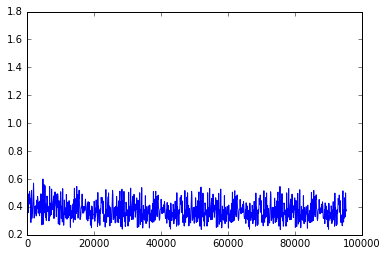

In [135]:
plt.plot(range(len(check._cost_list))[::100],check._cost_list[::100]);

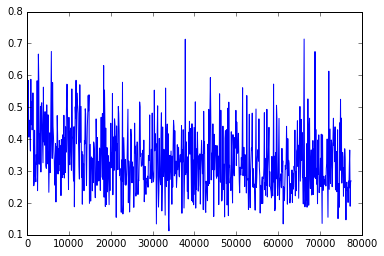

In [117]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(check._cost_list))[::100],check._cost_list[::100])

In [111]:
check.predict(os.path.join(path,'data.csv'))

2,1,2,1,2,2,1,2,1,1,1,2,No error,2,1,1,1,1,1,1,2,1,1,1,1,1,1


In [95]:
check.check_results()

		Predicted:
		min. maj.
Actual:	 min. [5794  441]
    	 maj. [1120 1280]


In [ ]:
# just checking again with default pattern
# just to compare errors. with 83.232 it was: 
#(top left top right bot left bot right) 
######## '[\w+\']+': 5740-495-1022-1378 (is that first plus supposed to be there?)

#default: 5725-530-929-1407 BUT 437 bad

# '[\w\']+(\-[\w]+)?': 5751-484-1127-1273

without the plus
#'[\w\']+': 5720-515-1023-1377

# shouldn'e actually make a difference; there are no plusses in there
# but run again... 5794-441-1120-1280

# don't forget to delete self.bad

In [79]:
print(sum([5740,495,1022,1378]))
print(sum([5725,530,929,1407]))

8635
8591


In [59]:
token_pattern = '[\w\']+(\-[\w]+)?'
len(check.bad) 0
82.682

token_pattern = '[\w+\']+'
len(check.bad) 0
83.232

0

In [51]:
# len(check.bad) ##438
# check.bad[258] ##74571
# check.raw_X[74571] ##array(['', ''], dtype='|S2952')
# manually deleted it

74571

In [55]:
for i,row in enumerate(check.raw_X[check.bad]):
    try:
        CountVectorizer(token_pattern='[\w\']+(\-[\w]+)?').fit([row[0],row[1]]).get_feature_names()
    except:
        print(i) #just 258

258


In [119]:
check.predict(os.path.join(path,'data.csv'))

1,1,2,1,1,2,1,2,1,1,1,2,No error,2,1,1,1,1,1,2,2,1,1,1,1,2,1


In [ ]:
# original
1 loop, best of 3: 10.6 s per loop
# moving graph build to beginning of predict -- ramifications for batches and such??
1 loop, best of 3: 4.84 s per loop
# initialize session first, but all unknowns except no error
1 loop, best of 3: 526 ms per loop
# forgot to indent everything after tf.Session()... winnar
1 loop, best of 3: 1.12 s per loop